# Prediction of Google Quick Draw images

In 2018 Google hosted a game called **_Quick, Draw!_** where players were given 20 seconds to draw an object based on a word prompt such as "mountain", "sun", "beard".  Google had a neural net trained to guess the image as the player was drawing it (and presumably had some ongoing reinforcement learning occurring, too). They've open sourced all (?) the sketches for people to play with.

- [Quick, Draw! main data page](https://quickdraw.withgoogle.com/data)
- [Project GitHub Repo](https://github.com/googlecreativelab/quickdraw-dataset)
- [Google cloud storage for all sketches](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1)

I've downloaded 6 classes of sketches. These drawings have been rendered into a 28x28 grayscale bitmap and are aligned to the center of the drawing's bounding box. Originally, these classes have ~150k samples, but I've randomally sampled 10,000 samples of each class. I've chosen two dominant groups of sketches: wing-dominated, and cicular.  In the first group are fish, bowtie, and angel.  The second group consists of basketball, baseball, and face.

The goal will be to predict what the sketch is trying to represent.  To do this we'll run a Restricted Boltzmann Machine to extract 10 useful features from each drawing class.  Then we'll feed those features into a fairly simplistic logistic regression and random forest.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.utils import shuffle
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

%matplotlib inline

In [2]:
# Loading 10,000 image random subsets of each dataset
fish = np.load('./QuickDrawImages/fish_10k.npy')
bowtie = np.load('./QuickDrawImages/bowtie_10k.npy')
angel = np.load('./QuickDrawImages/angel_10k.npy')
basketball = np.load('./QuickDrawImages/basketball_10k.npy')
baseball = np.load('./QuickDrawImages/baseball_10k.npy')
face = np.load('./QuickDrawImages/face_10k.npy')

In [3]:
print(fish.shape)
print(bowtie.shape)
print(angel.shape)
print(basketball.shape)
print(baseball.shape)
print(face.shape)

(10000, 784)
(10000, 784)
(10000, 784)
(10000, 784)
(10000, 784)
(10000, 784)


We have 6 sets of 10,000 drawings each:
- Fish
- Bowtie
- Angel
- Basketball
- Baseball
- Face

The first three are dominantly "wing-shaped" and the second three are "ball-shaped with lines". 

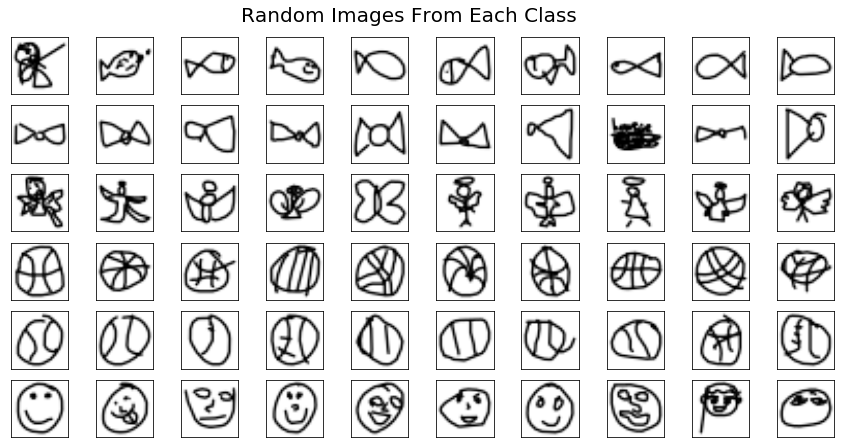

In [4]:
# Plotting random examples from each class

index = []
for i in range(10):
    index.append(random.randint(0,10000))

image_classes = [fish, bowtie, angel, basketball, baseball, face]

counter = 1

plt.figure(figsize=(15,7))
plt.suptitle('Random Images From Each Class', size=20)

for ic in image_classes:
    for idx in index:
        plt.subplot(6,10,counter)
        plt.imshow(ic[idx].reshape((28, 28)), cmap="Greys", interpolation='bilinear')
        plt.xticks(())
        plt.yticks(())
        
        counter += 1

plt.subplots_adjust(top=.92)
plt.show()

The individual images are unsigned 8-bit which means their values are scaled from (0, 255).  The SKlearn RBM implementation requires that the values be scaled from (0, 1).

In [5]:
def scale(X, eps = 0.001):
    # Scale the data points so that the values are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

fish = scale(fish)
bowtie = scale(bowtie)
angel = scale(angel)
basketball = scale(basketball)
baseball = scale(baseball)
face = scale(face)

# Qualitative Feature Visualization

RBMs output features which can be qualitatively judged for representativeness.  Doing this visual QC ensures that we have a variety of useful features being input into the model.  After doing some manual grid searching through the hyperparameter space, I've landed on a set of hyperparameters which work well for every class and don't take too long to run.

First let's visualize these potential features.  Then, **_after_** splitting the data, we will run RBMs for each class again to ensure that we do not train on our test images.

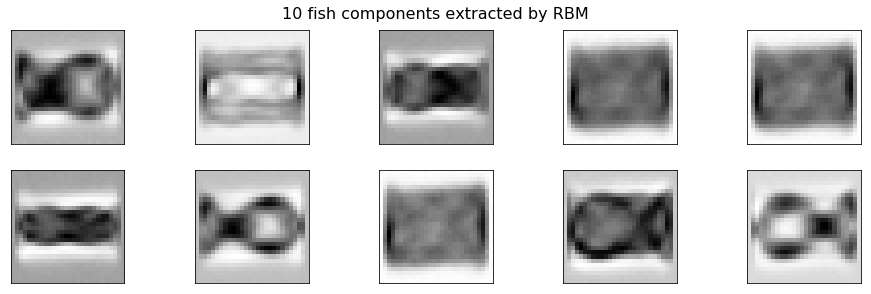

In [6]:
# RBM instantiation for the all fish images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(fish)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), 
               cmap="Greys", 
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 fish components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

Note that these features look like bowties because there was not a defined direction to draw the fish.  Apparently users drew fish facing each direction about equally.  (Editor's note: I much prefer a left-facing fish) After hyperparameter searching, there seems to be no additional useful features to extract.

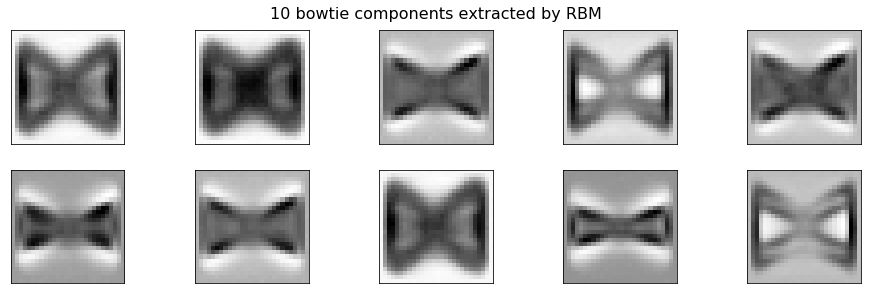

In [7]:
# RBM instantiation for all bowtie images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(bowtie)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 bowtie components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

The bowties are much more symetrical than the fish features.

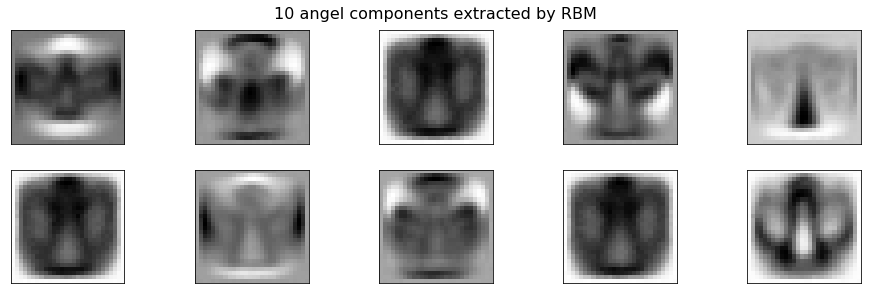

In [8]:
# RBM instantiation for all angel images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(angel)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 angel components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

These are pretty creepy, sort of nightmarish!

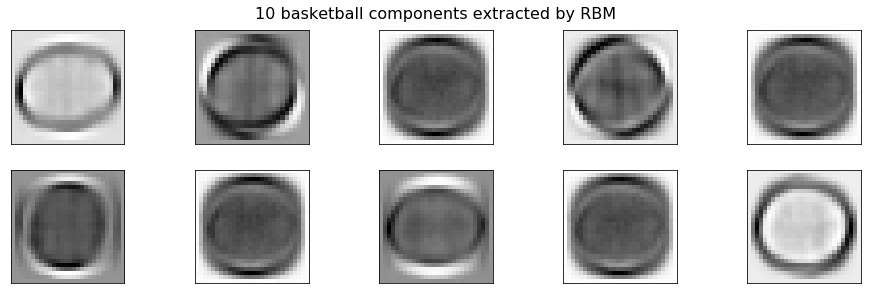

In [9]:
# RBM instantiation for all basketball images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(basketball)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 basketball components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

Basketballs appear to more or less circular objects with many lines.

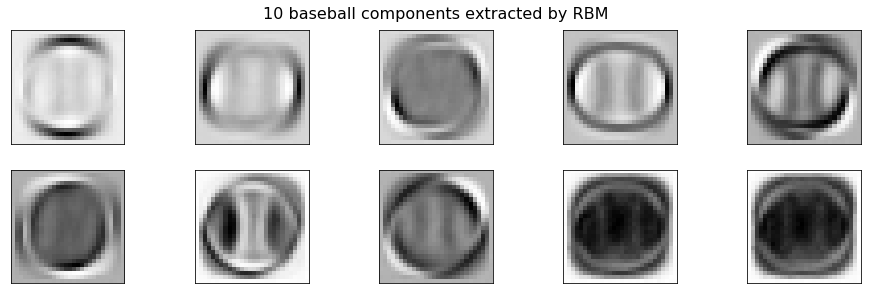

In [10]:
# RBM instantiation for all baseball images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(baseball)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 baseball components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

Baseballs are circles with two outwardly curving lines.

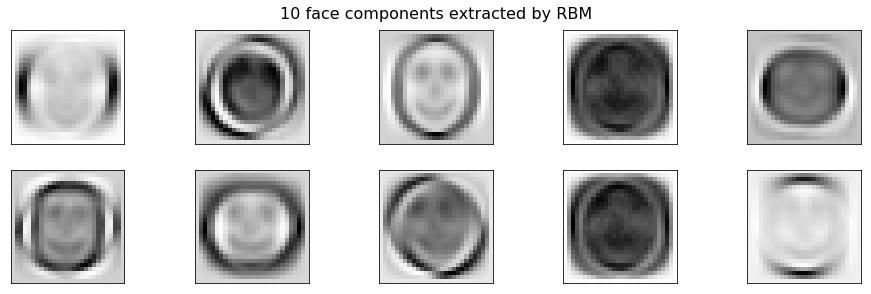

In [11]:
# RBM instantiation for all face images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(face)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 face components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

These are, well, faces.

# Train-Test Split

We will need to split this data manually, train an individual RBM model for training set of each class, and then combine all the train and test classes together.

The data provided by Google was presumably distributed in a random fashion, however, before I cut the 10,000 sample subsets out, I shuffled the data.  So it is demonstrably random in its current state.  Therefore, I will use simple indexing to break out the train-test splits for each class. 

Images will be encoded as below:

**Image Class**
- Fish = 0
- Bowtie = 1
- Angel = 2
- Basketball = 3
- Baseball = 4
- Face = 5

In [12]:
def rbm_train_test_split(imclass, label):
    '''
    Function to split the class up 75%-25%, assign the proper class label, 
    and run the RBM on the x_train data.
    Returns the four usual train test split outputs.
    '''
    x_train = imclass[:7500]
    x_test = imclass[7500:]
    
    y_train = [label for i in range(7500)]
    y_test = [label for i in range(2500)]
    
    rbm = BernoulliRBM(n_components=10, 
                         learning_rate=0.001, 
                         batch_size=10, 
                         n_iter=100)
    
    # Fitting the model to the training subset
    x_rbm_train = rbm.fit_transform(x_train)
    
    # Transforming the test subset to contain the same number of features
    x_rbm_test = rbm.transform(x_test)
    
    return x_rbm_train, x_rbm_test, y_train, y_test

In [13]:
# Train test splits for each class

X_fish_train, X_fish_test, Y_fish_train, Y_fish_test = rbm_train_test_split(fish, 0)

X_bowtie_train, X_bowtie_test, Y_bowtie_train, Y_bowtie_test = rbm_train_test_split(bowtie, 1)

X_angel_train, X_angel_test, Y_angel_train, Y_angel_test = rbm_train_test_split(angel, 2)

X_basketball_train, X_basketball_test, Y_basketball_train, Y_basketball_test = rbm_train_test_split(basketball, 3)

X_baseball_train, X_baseball_test, Y_baseball_train, Y_baseball_test = rbm_train_test_split(baseball, 4)

X_face_train, X_face_test, Y_face_train, Y_face_test = rbm_train_test_split(face, 5)

Let's make sure we have valid data after splitting it.

In [14]:
X_face_train.shape

(7500, 10)

In [15]:
X_face_train[0,:].shape

(10,)

Great. So we have 7,500 samples in the training set and each contains 10 features.  Let's concatenate all the data together.  Then we'll shuffle it so the classes are randomly distributed throughout the training and testing set.

In [17]:
# Combining the individual train test splits

X_train = np.concatenate((X_fish_train, 
                          X_bowtie_train, 
                          X_angel_train, 
                          X_basketball_train, 
                          X_baseball_train, 
                          X_face_train), 
                         axis=0)

X_test = np.concatenate((X_fish_test, 
                          X_bowtie_test, 
                          X_angel_test, 
                          X_basketball_test, 
                          X_baseball_test, 
                          X_face_test), 
                         axis=0)

Y_train = np.concatenate((Y_fish_train, 
                          Y_bowtie_train, 
                          Y_angel_train, 
                          Y_basketball_train, 
                          Y_baseball_train, 
                          Y_face_train), 
                         axis=0)

Y_test = np.concatenate((Y_fish_test, 
                          Y_bowtie_test, 
                          Y_angel_test, 
                          Y_basketball_test, 
                          Y_baseball_test, 
                          Y_face_test), 
                         axis=0)

In [18]:
# Shuffling the samples so the order they're in does not matter
X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)

# Classification Models

Now that we have the feature engineering complete and the data set split, it's time to run some models.  We'll keep these pretty simple, though, do note that the hyperparameters have been optimized via a grid search.  

First up is a logistic regression.

In [19]:
# Grid searched multinomial logistic regression
ridge = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           penalty='l2', 
                           max_iter=10000, 
                           C=100, 
                           n_jobs=3)

ridge.fit(X_train, Y_train)

Y_pred = ridge.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2500
           1       0.91      0.97      0.94      2500
           2       0.88      0.88      0.88      2500
           3       0.93      0.96      0.95      2500
           4       0.86      0.91      0.88      2500
           5       0.99      0.88      0.93      2500

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



That's a pretty great model with an F1 score of 0.90.  But logistic regressions are pretty simple.  Perhaps we can get some extra performance from a tree-based model?

Next up is a random forest.

In [20]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=25, max_depth=10, n_jobs=-1)
rf.fit(X_train, Y_train)

Y_rf_pred = rf.predict(X_test)

print(classification_report(Y_test, Y_rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2500
           1       1.00      1.00      1.00      2500
           2       1.00      1.00      1.00      2500
           3       1.00      1.00      1.00      2500
           4       1.00      1.00      1.00      2500
           5       1.00      1.00      1.00      2500

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



Whoa.  A perfect model?!  And it has small, reasonably sized trees, too.  That's pretty awesome!

# Potential Next Steps

So we have a perfect model for 6 classes of 10k samples, each.  What if we used _all_ of the 150k original sketches per class.  Surely some people are so bad at drawing that our model wouldn't be perfect.  

Additionally, we could add many more different classes.  The original _**Quick! Draw**_ dataset contains 345 classes.  Many of those are not simple to draw or evoke a similar mental image in everyone -- I would imagine that something like a backpack or lion would yield many different results.    